In [1]:
library(tidyverse)
library(repr)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [2]:
forest_fire<-read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv', skip=1,
                     )%>%
    select(Temperature,Ws,RH,Rain,Classes)%>%
    mutate(Classes=as_factor(Classes),
        Temperature=as.numeric(Temperature),   
        RH=as.numeric(RH),
        Rain=as.numeric(Rain ),
        Ws=as.numeric(Ws))%>%
        filter(Classes!='Classes',
                Temperature!='NA',
                  RH!='NA',
                  Rain!='NA',
                    Ws!='NA')

forest_fire

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_character(),
  Temperature = col_character(),
  RH = col_character(),
  Ws = col_character(),
  Rain = col_character(),
  FFMC = col_character(),
  DMC = col_character(),
  DC = col_character(),
  ISI = col_character(),
  BUI = col_character(),
  FWI = col_character(),
  Classes = col_character()
)

Warning message:
“2 parsing failures.
row col   expected     actual                                                                                                       file
123  -- 14 columns 1 columns  'https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv'
168  -- 14 columns 13 columns 'https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv'
”
Warning message:
“Problem with `mutate()` input `Temperature`.
ℹ NAs introduced by coercion
ℹ Input `Temperature` is `as.numeric(Temperature)`.

Temperature,Ws,RH,Rain,Classes
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
29,18,57,0.0,not fire
29,13,61,1.3,not fire
26,22,82,13.1,not fire
25,13,89,2.5,not fire
27,16,77,0.0,not fire
31,14,67,0.0,fire
33,13,54,0.0,fire
30,15,73,0.0,fire
25,13,88,0.2,not fire


`summarise()` ungrouping output (override with `.groups` argument)



Classes,Rain,RH,Ws,Temperature
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
not fire,1.62452830,69.31132,15.71698,30.02830
fire,0.09635036,56.41606,15.32117,33.79562


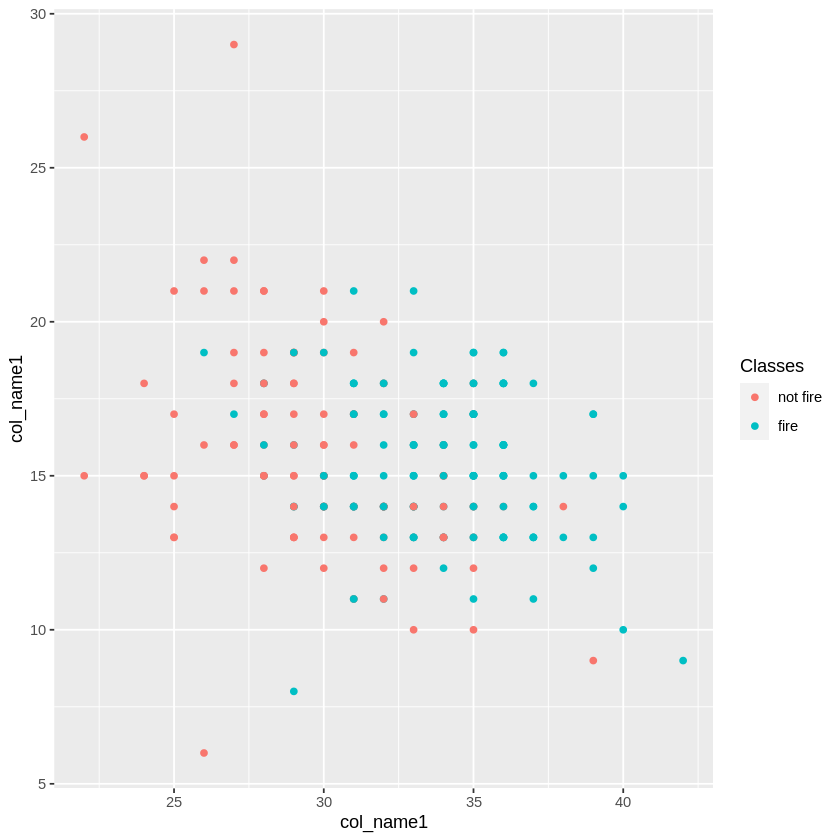

In [4]:
vacc_plot<- forest_fire%>%
    ggplot(aes(x= Temperature, y= Ws, color=Classes))+
    geom_point()+
    xlab('col_name1')+
    ylab('col_name1')
vacc_plot